In [1]:
import numpy as np
import proplot as plot

import pyart
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('breezy_tools.py'))))
import breezy_tools as tools
import breezy_simulator as simulator
import breezy_operators as operators
import breezy_util_operators as utility
import breezy_interpolation as interpolator
import warnings
from tqdm import tqdm
from scipy.spatial import cKDTree
import multiprocessing as mp
import xarray as xr
from scipy.signal import savgol_filter
from scipy.interpolate import RegularGridInterpolator
from savitzkygolay import filter3D


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [16]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    radar = pyart.io.read("/home/564/jb2354/dev/breezy/media/small_field_high_res_noisy.nc")

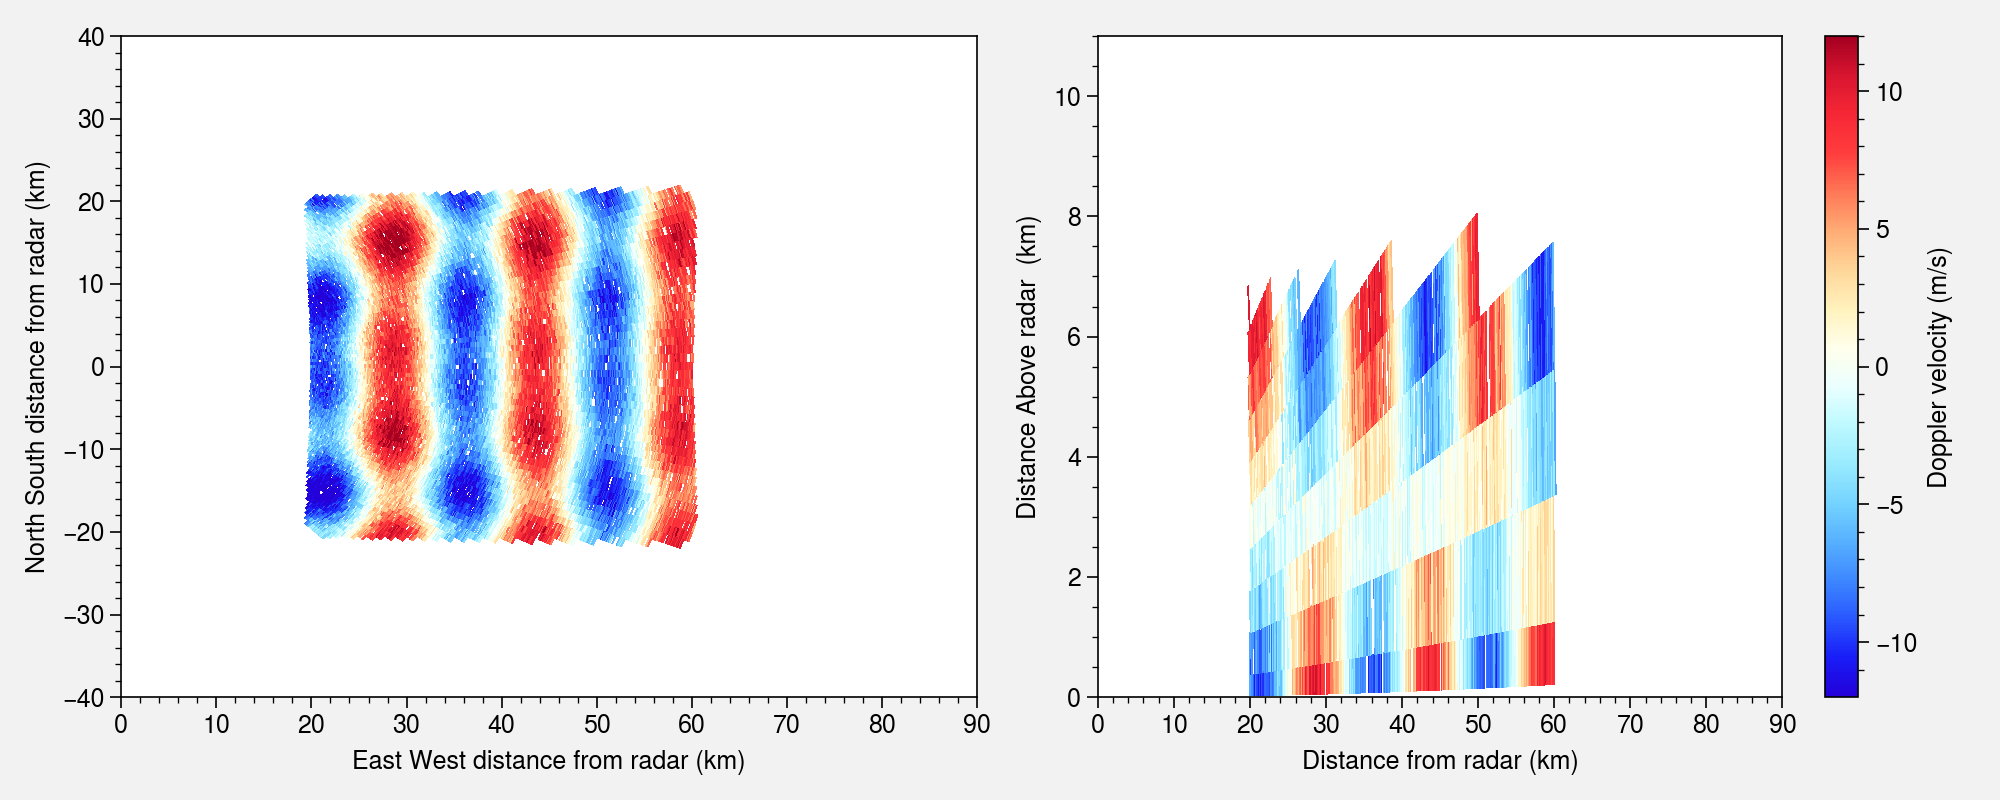

In [17]:
# create the plot using RadarDisplay
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)
display.plot('velocity', 0, ax=ax,colorbar_flag= False,
             colorbar_label='',vmin = -12, vmax = 12, title=  '',)
display.set_limits((0, 90), (-40, 40), ax=ax)

xsect = pyart.util.cross_section_ppi(radar, [90])
display = pyart.graph.RadarDisplay(xsect)
ax = fig.add_subplot(122)
display.plot('velocity', 0, vmin = -12, vmax = 12,title=  '')
display.set_limits((0, 90), (0, 11), ax=ax)
plt.tight_layout()
plt.suptitle('wyel', y=1.05)
plt.show()

In [18]:
# create a realistically sized grid
sim = tools.test_field('wuest', n = (25, 161, 161), noise = 0, bounds = ((1,6001),(-20000,20000),
    (-20000,20000)), radars = ((0, -0, -40000), ), bg_wind = (0,0), A = 20, H = 6000, L = 15000, 
       center_grid = (-27.4698,153.0251), include_const_dbz = 1e-3, mask_center = (0,1), mask_size = 100, seed = 0)
W, V, U = sim.grids[0].fields['We']['data'], sim.grids[0].fields['Ve']['data'], sim.grids[0].fields['Ue']['data']
dop = np.moveaxis(np.array([np.ma.filled(grid.fields['doppler']['data'], fill_value = 0) for grid in sim.grids]),0,-1)
fref = dop[...,0]
coords = (sim.z-sim.radars[0][0], sim.y-sim.radars[0][1], sim.x-sim.radars[0][2])

In [19]:
coords = (sim.z-sim.radars[0][0], sim.y-sim.radars[0][1], sim.x-sim.radars[0][2])
interp_field = interpolator.cressman_ppi_interp(radar, coords, 1200, 'velocity', k=500, filter_its = 0, window_length = 11, polyorder=5) 

Interpolating...
Done!


/home/564/jb2354/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:3225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/home/564/jb2354/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:3257: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


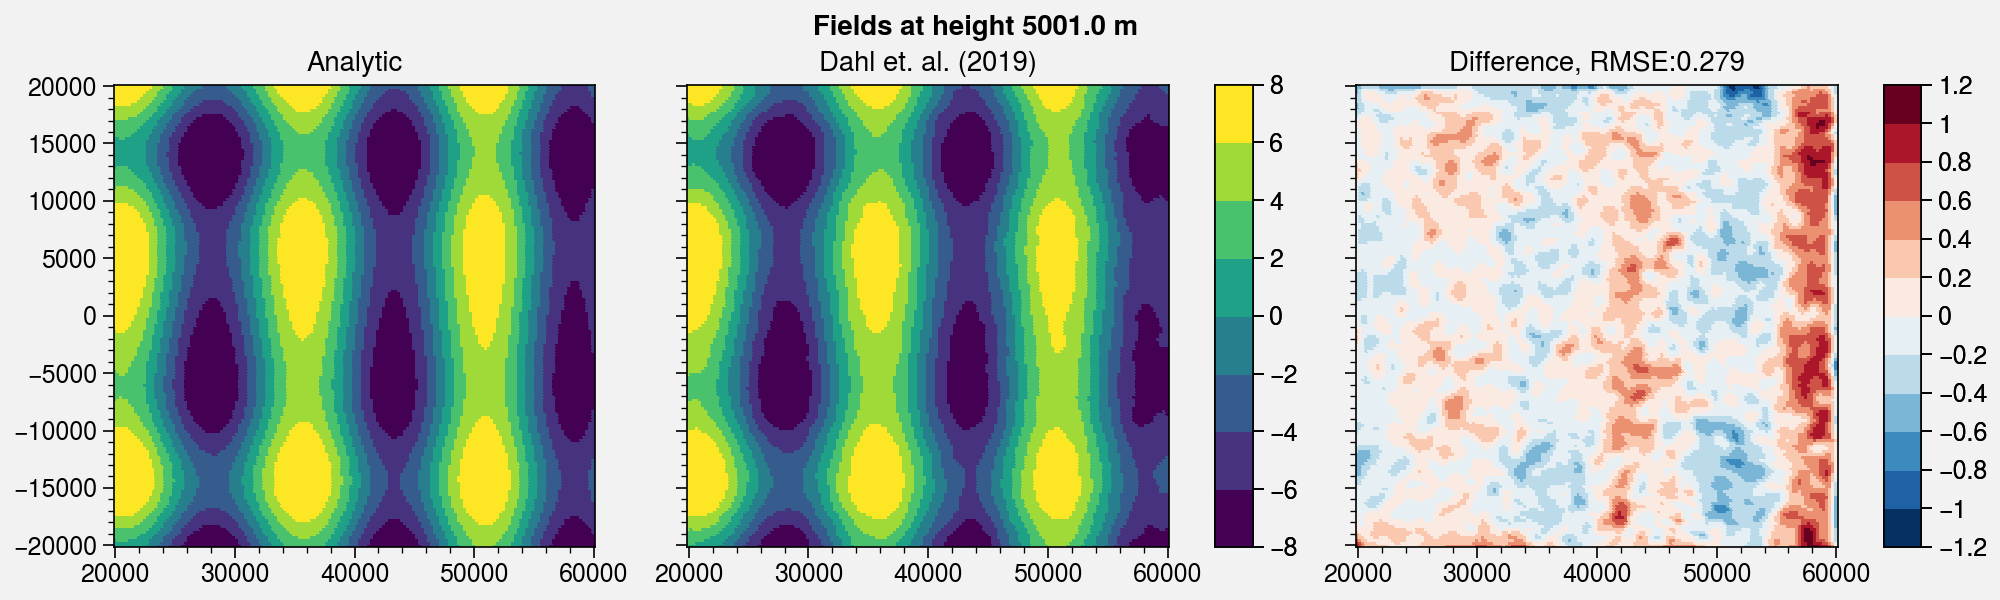

In [15]:
idx = 20
fig, axs = plot.subplots(ncols = 3, figsize=(10,3))
fields = [fref[idx,...], interp_field[idx,...]]
minmax = [min([np.amin(field) for field in fields]), max([np.amax(field) for field in fields])]
fields.append(fields[1]- fields[0])
axs[0].pcolormesh(coords[2], coords[1], fields[0], cmap = 'viridis', vmin = minmax[0], vmax = minmax[1])
axs[0].format(title = 'Analytic')
axs[1].pcolormesh(coords[2], coords[1], fields[1], cmap = 'viridis', colorbar = 'r', vmin = minmax[0], vmax = minmax[1])
axs[1].format(title = 'Dahl et. al. (2019)')
axs[2].pcolormesh(coords[2], coords[1], fields[2], cmap = 'RdBu_r', colorbar = 'r', norm = 'diverging')
axs[2].format(title = 'Difference, RMSE:'+str(np.round(np.sqrt((fields[2][~np.isnan(fields[2])]**2).mean()),3)))

axs.format(suptitle = 'Fields at height {} m'.format(coords[0][idx]))
plot.show()

In [ ]:
tilt = 8
fig, axs = plot.subplots(ncols = 2, figsize=(9,4))
axs[0].pcolormesh(coords[2], coords[1], ppi_height[tilt,...], cmap = 'viridis', colorbar = 'r')
axs[0].format(title = 'Gridded height')
axs[1].pcolormesh(coords[2], coords[1], field[tilt,...],  cmap = 'viridis', colorbar = 'r')
axs[1].format(title = 'Gridded field')
axs.format(xlim = [20000,60000], ylim = [-20000, 20000])
plot.show()

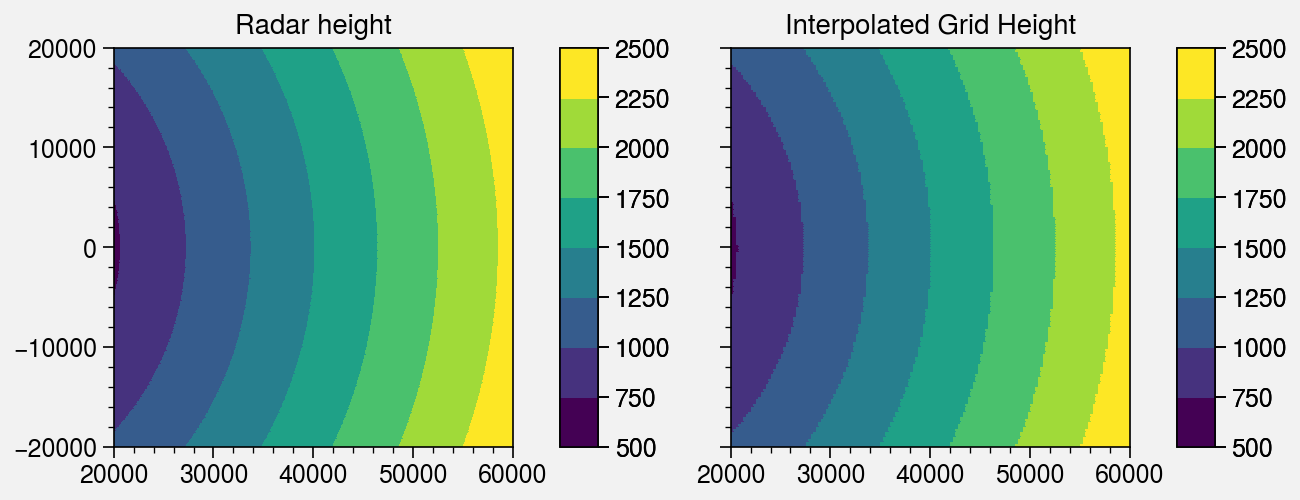

In [383]:
tilt = 1
fig, axs = plot.subplots(ncols = 2, journal = 'ams4')
x,y,z = radar.get_gate_x_y_z(tilt)
fields = [z, ppi_height[tilt,...]]
minmax = [min([np.amin(field) for field in fields]), max([np.amax(field) for field in fields])]
axs[0].pcolormesh(x,y,fields[0], cmap = 'viridis', colorbar = 'r', vmin = minmax[0], vmax = minmax[1])
axs[0].format(title = 'Radar height')
axs[1].pcolormesh(coords[2], coords[1], fields[1], cmap = 'viridis', colorbar = 'r', vmin = minmax[0], vmax = minmax[1])
axs[1].format(title = 'Interpolated Grid Height')
axs.format(xlim = [20000,60000], ylim = [-20000, 20000])
plot.show()